In [1]:
import pandas as pd 
import numpy as np
from scipy import stats
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from lifetimes import ParetoNBDFitter
from lifetimes import BetaGeoFitter
import lifetimes
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.utils import summary_data_from_transaction_data
from pymc_marketing import clv
from probabilistic_util_fuctions import generate_rfm_data2, generate_rfm_data

In [3]:
df = pd.read_csv('online_retail_II.csv')
df.rename(columns = {'Customer ID':'CustomerID', 
                     'Price': 'UnitPrice', 
                     'Invoice': "InvoiceNo"}, inplace = True)


df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [4]:
df.describe(include='all')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,1067371,1067371,1062989,1.067371e+06,1067371,1.067371e+06,824364.000000,1067371
unique,53628,5305,5698,NaN,47635,NaN,NaN,43
top,537434,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,2010-12-06 16:57:00,NaN,NaN,United Kingdom
freq,1350,5829,5918,NaN,1350,NaN,NaN,981330
mean,NaN,NaN,NaN,9.938898e+00,NaN,4.649388e+00,15324.638504,NaN
std,NaN,NaN,NaN,1.727058e+02,NaN,1.235531e+02,1697.464450,NaN
min,NaN,NaN,NaN,-8.099500e+04,NaN,-5.359436e+04,12346.000000,NaN
25%,NaN,NaN,NaN,1.000000e+00,NaN,1.250000e+00,13975.000000,NaN
50%,NaN,NaN,NaN,3.000000e+00,NaN,2.100000e+00,15255.000000,NaN
75%,NaN,NaN,NaN,1.000000e+01,NaN,4.150000e+00,16797.000000,NaN


In [5]:
def data_preprocessing(df):

    df = df[df['CustomerID'].notna()].reset_index(drop=True)
    df = df[df.Quantity > 0]
    df = df[df.UnitPrice > 0]
    non_product_codes = ['POST', 'D', 'M', 'C2', 'BANK CHARGES', 'AMAZONFEE', 'DCGSSBOY', 
                         'DCGSSGIRL', 'DOT', 'PADS', 'TEST001','TEST002', 'ADJUST', 'ADJUST2','SP1002']

    df = df[~df['StockCode'].isin(non_product_codes)]

    #time features engeneering
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
    df['Date'] = df['InvoiceDate'].dt.date
    df['Month'] = df['InvoiceDate'].dt.to_period('M')
    df['day_of_week'] = df['InvoiceDate'].dt.dayofweek
    df['hour_minute'] = df['InvoiceDate'].dt.time

    df['day_sin'] = np.sin(2*np.pi*df['day_of_week']/7)
    df['day_cos'] = np.cos(2*np.pi*df['day_of_week']/7)

    morning_time = pd.to_datetime('12:00:00').time()
    afternoon_time = pd.to_datetime('18:00:00').time()
    df['time_of_day'] = df['hour_minute'].apply(lambda x: 'morning' if x < morning_time
                                                                        else 'afternoon' if (x < afternoon_time and x >= morning_time)
                                                                        else 'evening')
    
    df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
    df['Amount'] = df['Quantity'] * df['UnitPrice']
    df = df[(np.abs(stats.zscore(df['TotalPrice'])) < 3)]
    df = df[(np.abs(stats.zscore(df['Quantity'])) < 3)]
    
    # create first order of the customer column
    df['FirstOrder'] = df.groupby('CustomerID')['InvoiceDate'].transform('min')


    #ebedding for the country and description columns
    country_encoder = LabelEncoder()
    df['CountryID'] = country_encoder.fit_transform(df['Country'])
    desc_encoder = LabelEncoder()
    df['DescriptionID'] = desc_encoder.fit_transform(df['Description'])
    #define embedding layers to be used in the model
    num_countries = df.CountryID.nunique()
    num_description = df.DescriptionID.nunique()
    country_embedding = nn.Embedding( num_embeddings=num_countries, embedding_dim = 4)
    description_embedding = nn.Embedding(num_embeddings=num_description, embedding_dim = 16)
    df = df[df.Month != '2011-12']

    return df

def get_orders_df(df): 
    rfm_data, orders_df= generate_rfm_data(df)
    orders_df1 = df.groupby('InvoiceNo').agg({
                                                'InvoiceDate': 'first',
                                                'Month': 'first',
                                                'hour_minute': 'first',
                                                'day_of_week': 'first',
                                                'day_sin': 'first',
                                                'day_cos': 'first',
                                                'StockCode': 'nunique',
                                                }).reset_index()
    orders_df = orders_df1.merge(orders_df, on='InvoiceNo', how='left')
    orders_df.rename(columns = {'StockCode':'unique_per_order'}, inplace = True)
    morning_time = pd.to_datetime('12:00:00').time()
    afternoon_time = pd.to_datetime('18:00:00').time()
    orders_df['time_of_day'] = orders_df['hour_minute'].apply(lambda x: 'morning' if x < morning_time
                                                                        else 'afternoon' if (x < afternoon_time and x >= morning_time)
                                                                        else 'evening')
    comon_type_od_day = orders_df.groupby('CustomerID')['time_of_day'].agg(lambda x:x.value_counts().idxmax()).reset_index(name = 'most_common_time_of_day')
    n_unique_items = df.groupby('CustomerID')['StockCode'].nunique().reset_index(name = 'n_unique_items')
    country_ID = df.groupby('CustomerID')['CountryID'].first().reset_index(name = 'CountryID')

    customer_df = orders_df.groupby('CustomerID')['unique_per_order'].mean().reset_index()
    customer_df = customer_df.merge(n_unique_items, on='CustomerID', how='left')
    customer_df = customer_df.merge(comon_type_od_day, on='CustomerID', how='left')
    customer_df = customer_df.merge(country_ID, on='CustomerID', how='left')
    customer_df = pd.get_dummies(customer_df, columns=['most_common_time_of_day'], prefix='in_').astype(int)
    customer_df = customer_df.merge(rfm_data, on='CustomerID', how='left')
    customer_df['avg_time_between_orders'] = customer_df['recency']/customer_df['frequency']
    customer_df['days_since_last_order'] = customer_df['T'] - customer_df['recency']
    customer_df['TotalPrice '] = customer_df['frequency'] * customer_df['monetary_value']
    
    return orders_df, customer_df

In [6]:
pp_df = data_preprocessing(df)
orders_df, rfm_df = get_orders_df(pp_df)

rfm_df.head()

,CustomerID,unique_per_order,n_unique_items,CountryID,in__afternoon,in__evening,in__morning,frequency,recency,T,monetary_value,avg_time_between_orders,days_since_last_order,TotalPrice
0,12346,12,24,38,1,0,0,2.0,118.0,647.0,84.680000,59.000000,529.0,169.36
1,12347,30,122,16,1,0,0,7.0,365.0,404.0,736.985714,52.142857,39.0,5158.90
2,12348,8,24,12,1,0,0,5.0,363.0,438.0,331.680000,72.600000,75.0,1658.40
3,12349,57,137,18,0,0,1,3.0,571.0,589.0,1226.230000,190.333333,18.0,3678.69
4,12350,16,16,26,1,0,0,1.0,0.0,310.0,294.400000,0.000000,310.0,294.40


In [7]:
rfm_df.describe()

,CustomerID,unique_per_order,n_unique_items,CountryID,in__afternoon,in__evening,in__morning,frequency,recency,T,monetary_value,avg_time_between_orders,days_since_last_order,TotalPrice
count,5790.000000,5790.000000,5790.000000,5790.000000,5790.000000,5790.000000,5790.000000,5790.000000,5790.000000,5790.000000,5790.000000,5790.000000,5790.000000,5790.000000
mean,15321.618307,21.172539,81.462349,36.196546,0.711572,0.010881,0.277547,5.480829,268.545769,475.251986,368.915875,52.775834,206.706218,2454.057206
std,1712.490182,18.440778,114.866015,6.544298,0.453071,0.103751,0.447828,9.633905,255.348708,221.493545,368.630273,56.949077,205.726692,8447.848137
min,12346.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,9.000000,2.900000,0.000000,9.000000,2.900000
25%,13843.250000,10.000000,19.000000,38.000000,0.000000,0.000000,0.000000,1.000000,0.000000,317.000000,185.111875,0.000000,32.000000,332.467500
50%,15323.500000,17.000000,44.000000,38.000000,1.000000,0.000000,0.000000,3.000000,217.000000,529.000000,292.733065,39.500000,108.000000,841.190000
75%,16802.750000,27.000000,102.000000,38.000000,1.000000,0.000000,1.000000,6.000000,503.000000,666.750000,430.667250,80.121528,380.000000,2167.877500
max,18287.000000,283.000000,2508.000000,40.000000,1.000000,1.000000,1.000000,242.000000,729.000000,738.000000,8951.260000,357.000000,738.000000,323131.200000


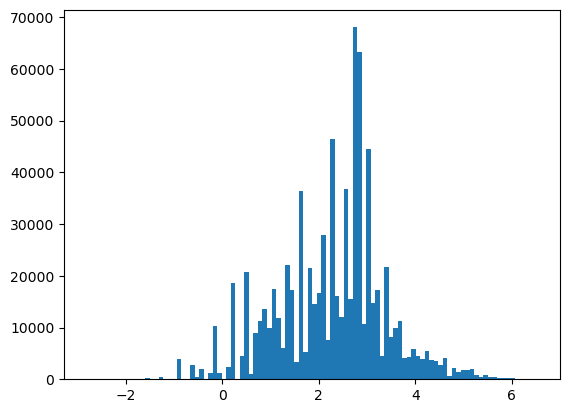

In [8]:
import matplotlib.pyplot as plt

plt.hist(np.log(pp_df['Amount']), bins=100)
plt.show()

In [9]:
rfm_df.describe()

,CustomerID,unique_per_order,n_unique_items,CountryID,in__afternoon,in__evening,in__morning,frequency,recency,T,monetary_value,avg_time_between_orders,days_since_last_order,TotalPrice
count,5790.000000,5790.000000,5790.000000,5790.000000,5790.000000,5790.000000,5790.000000,5790.000000,5790.000000,5790.000000,5790.000000,5790.000000,5790.000000,5790.000000
mean,15321.618307,21.172539,81.462349,36.196546,0.711572,0.010881,0.277547,5.480829,268.545769,475.251986,368.915875,52.775834,206.706218,2454.057206
std,1712.490182,18.440778,114.866015,6.544298,0.453071,0.103751,0.447828,9.633905,255.348708,221.493545,368.630273,56.949077,205.726692,8447.848137
min,12346.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,9.000000,2.900000,0.000000,9.000000,2.900000
25%,13843.250000,10.000000,19.000000,38.000000,0.000000,0.000000,0.000000,1.000000,0.000000,317.000000,185.111875,0.000000,32.000000,332.467500
50%,15323.500000,17.000000,44.000000,38.000000,1.000000,0.000000,0.000000,3.000000,217.000000,529.000000,292.733065,39.500000,108.000000,841.190000
75%,16802.750000,27.000000,102.000000,38.000000,1.000000,0.000000,1.000000,6.000000,503.000000,666.750000,430.667250,80.121528,380.000000,2167.877500
max,18287.000000,283.000000,2508.000000,40.000000,1.000000,1.000000,1.000000,242.000000,729.000000,738.000000,8951.260000,357.000000,738.000000,323131.200000


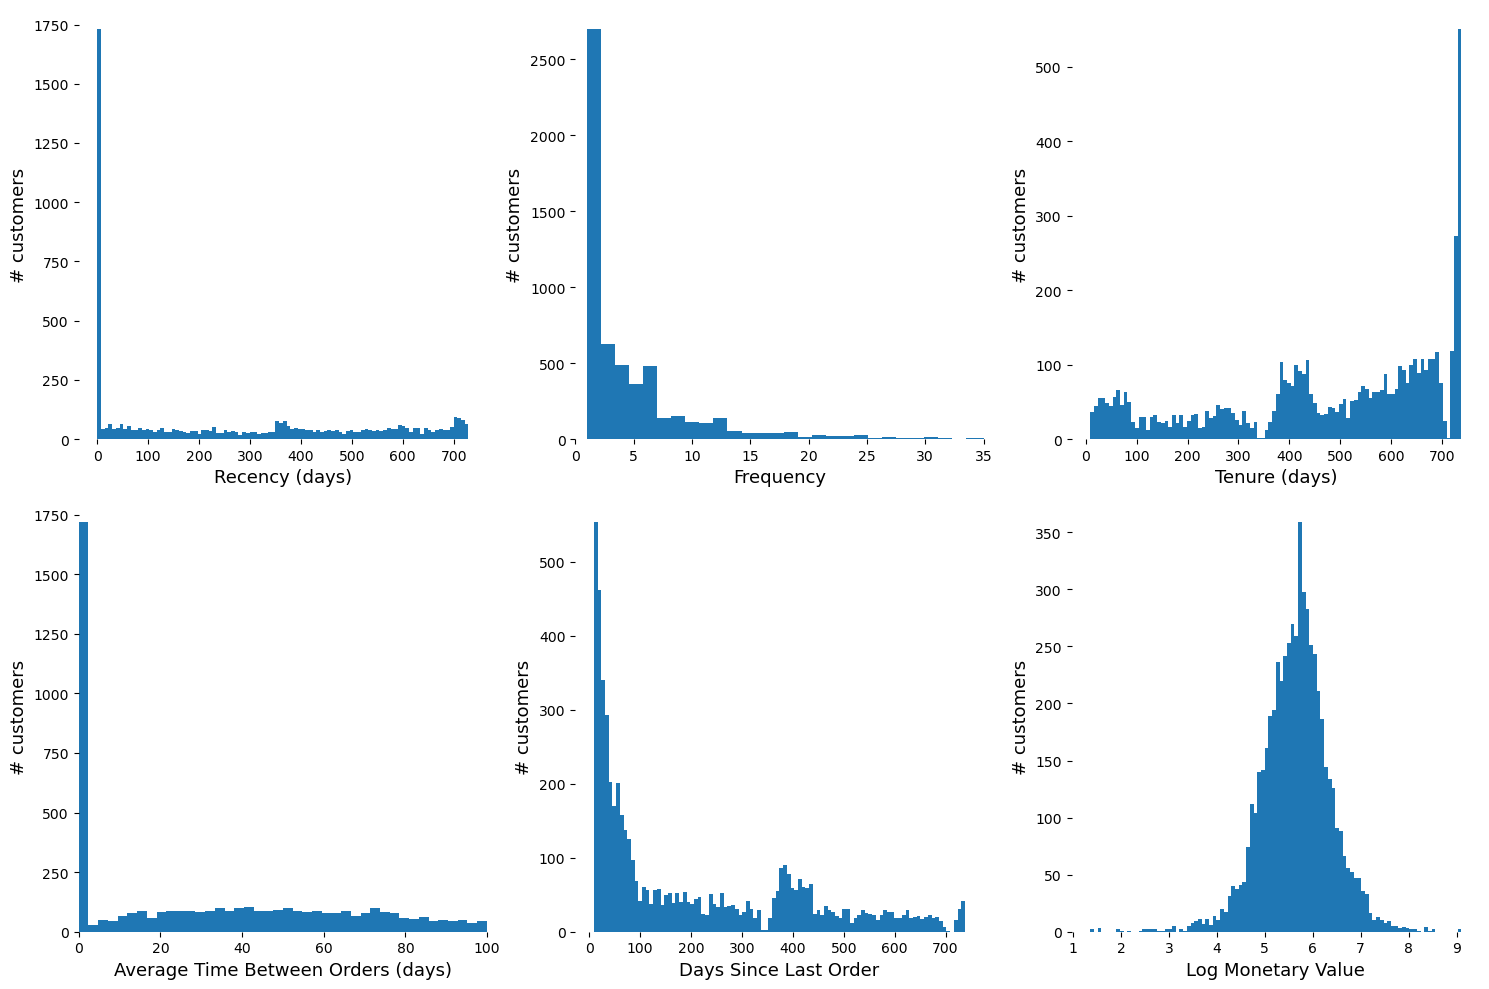

In [11]:
features_to_plot = ['recency', 'frequency', 'monetary_value','T', 'avg_time_between_orders', 'days_since_last_order']

plot_df = rfm_df[features_to_plot].copy()
plot_df['log monetary value']  = np.log(plot_df['monetary_value']+1)

fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for i in range(6):
    for spine in ax[i//3, i%3].spines.values():
        spine.set_visible(False)
   

ax[0, 0].hist(plot_df['recency'], bins=100)
ax[0,0].set_xlabel('Recency (days)', fontsize=13)
ax[0,0].set_ylabel('# customers', fontsize=13)

ax[0, 1].hist(plot_df['frequency'], bins=200)
ax[0,1].set_xlabel('Frequency', fontsize=13)
ax[0,1].set_ylabel('# customers', fontsize=13)
ax[0,1].set_xlim(0, 35)

ax[0, 2].hist(plot_df['T'], bins=100)
ax[0,2].set_xlabel('Tenure (days)', fontsize=13)
ax[0,2].set_ylabel('# customers', fontsize=13)

ax[1, 0].hist(plot_df['avg_time_between_orders'], bins=150)
ax[1,0].set_xlabel('Average Time Between Orders (days)', fontsize=13)
ax[1,0].set_ylabel('# customers', fontsize=13)
ax[1, 0].set_xlim(0, 100)

ax[1, 1].hist(plot_df['days_since_last_order'], bins=100)
ax[1,1].set_xlabel('Days Since Last Order', fontsize=13)
ax[1,1].set_ylabel('# customers', fontsize=13)

ax[1, 2].hist(plot_df['log monetary value'], bins=100)
ax[1,2].set_xlabel('Log Monetary Value', fontsize=13)
ax[1,2].set_ylabel('# customers', fontsize=13)

plt.tight_layout()

plt.savefig('rfm_features_histograms.png', dpi=350, bbox_inches='tight')
plt.show()



In [ ]:
rfm_df['Avg_number']